<center>
<img src="img/colorido-horizontal-ufc.png" alt="Drawing" style="width: 500px;"/>
</center>

## Introdução aos Métodos de Montecarlo

### Aula 05: Hard Disks -- Simulação de sistemas grandes

Prof. Saulo Reis (Depto. de Física - UFC)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Para barra de progresso}

%matplotlib inline

### Condições de contorno periódicas

In [2]:
def box_it(r, L):
    x = r[0] % L
    y = r[1] % L
    return np.array([x, y])

In [3]:
def diff_vec(r1, r2, L):
    dx = r1[0] - r2[0]
    dy = r1[1] - r2[1]

    dx -= L * np.round(dx / L)
    dy -= L * np.round(dy / L)
    return np.array([dx, dy])

### Esquema de Grid/Célula

In [4]:
def get_cell_index(pos, cell_size, n_cells):
    ix = int(pos[0] / cell_size) % n_cells
    iy = int(pos[1] / cell_size) % n_cells
    return ix, iy

### Esquema de Inicialização

In [5]:
def initialize_positions(N, r, L):
    positions = []
    n_side = int(np.sqrt(N))  # Número de partículas em cada lado
    spacing = L / n_side      # Espaçamento entre partículas

    if spacing < 2 * r:
        raise ValueError("Densidade muito alta para inicialização em rede sem sobreposição.")

    for i in range(n_side):
        for j in range(n_side):
            x = (i + 0.5) * spacing
            y = (j + 0.5) * spacing
            # Adicionar pequena perturbação aleatória
            x += np.random.uniform(-r * 0.1, r * 0.1)
            y += np.random.uniform(-r * 0.1, r * 0.1)
            positions.append(np.array([x % L, y % L]))
            if len(positions) == N:
                return np.array(positions)
    return np.array(positions)


In [6]:
def plot_particles(positions, L, r, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Seleciona uma partícula aleatoriamente para destacar
    random_index = np.random.randint(len(positions))
    
    for idx, pos in enumerate(positions):
        # Determina a cor: vermelho para a partícula selecionada, azul para as demais
        color = 'red' if idx == random_index else 'blue'
        # Desenhar a partícula original
        circle = plt.Circle(pos, r, color=color, alpha=0.5, ec='black')
        ax.add_artist(circle)
        
        x, y = pos
        shifts = []
        # Verificar se a partícula está próxima das bordas e adicionar deslocamentos
        if x - r < 0:
            shifts.append((L, 0))
        if x + r > L:
            shifts.append((-L, 0))
        if y - r < 0:
            shifts.append((0, L))
        if y + r > L:
            shifts.append((0, -L))
        # Verificar cantos
        if (x - r < 0) and (y - r < 0):
            shifts.append((L, L))
        if (x - r < 0) and (y + r > L):
            shifts.append((L, -L))
        if (x + r > L) and (y - r < 0):
            shifts.append((-L, L))
        if (x + r > L) and (y + r > L):
            shifts.append((-L, -L))
        
        # Desenhar as cópias periódicas
        for shift in shifts:
            shifted_pos = pos + shift
            circle = plt.Circle(shifted_pos, r, color=color, alpha=0.5, ec='black')
            ax.add_artist(circle)
    
    ax.set_aspect('equal')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('img/fig'+title+'.png')

In [7]:
def run_simulation(N, r, eta, num_steps, delta, plot=True):
    # Calcula o tamanho da caixa quadrada com base na densidade desejada
    area = (N * np.pi * r**2) / eta  # Área total necessária
    L = np.sqrt(area)  # Dimensão da caixa quadrada

    print(f"Tamanho da caixa: L = {L:.3f}")

    # Inicializa as posições das partículas em uma rede regular com perturbação
    print("Inicializando as posições das partículas...")
    positions = initialize_positions(N, r, L)
    positions_initial = positions.copy()

    # Configura a lista de células para verificações eficientes de sobreposição
    l_cell = 2.2 * r  # Um pouco maior que 2r para garantir que todas as possíveis sobreposições sejam consideradas
    n_cells = int(L / l_cell)
    n_cells = max(n_cells, 1)
    cell_size = L / n_cells

    cell_list = [[[] for _ in range(n_cells)] for _ in range(n_cells)]

    # Construir lista inicial de células
    for idx, pos in enumerate(positions):
        ix, iy = get_cell_index(pos, cell_size, n_cells)
        cell_list[ix][iy].append(idx)

    # Definir deslocamentos para acessar células vizinhas (incluindo a célula atual)
    neighbor_shifts = [(-1, -1), (-1, 0), (-1, 1),
                       ( 0, -1), ( 0, 0), ( 0, 1),
                       ( 1, -1), ( 1, 0), ( 1, 1)]

    if plot:
        plot_particles(positions_initial, L, r, f"Configuração Inicial (eta = {eta})")

    # Simulação de Monte Carlo
    print("Executando a simulação Monte Carlo...")
    for step in tqdm(range(num_steps)):
        i = np.random.randint(N)
        dx = np.random.uniform(-delta, delta)
        dy = np.random.uniform(-delta, delta)
        old_pos = positions[i]
        new_pos = positions[i] + np.array([dx, dy])
        new_pos = box_it(new_pos, L)
        # Obter índices de células antigos e novos
        old_ix, old_iy = get_cell_index(old_pos, cell_size, n_cells)
        new_ix, new_iy = get_cell_index(new_pos, cell_size, n_cells)
        # Verificar sobreposições com partículas em células vizinhas
        overlap = False
        for shift in neighbor_shifts:
            ix = (new_ix + shift[0]) % n_cells
            iy = (new_iy + shift[1]) % n_cells
            for j in cell_list[ix][iy]:
                if j != i:
                    dvec = diff_vec(new_pos, positions[j], L)
                    dist_sq = np.dot(dvec, dvec)
                    if dist_sq < (2 * r)**2:
                        overlap = True
                        break
            if overlap:
                break
        if not overlap:
            # Movimento aceito
            positions[i] = new_pos
            # Atualizar lista de células se a partícula mudou para uma nova célula
            if (old_ix, old_iy) != (new_ix, new_iy):
                cell_list[old_ix][old_iy].remove(i)
                cell_list[new_ix][new_iy].append(i)

    if plot:
        plot_particles(positions, L, r, f"Configuração Final (eta = {eta})")

    return positions_initial, positions, L

Tamanho da caixa: L = 40.933
Inicializando as posições das partículas...
Executando a simulação Monte Carlo...


100%|██████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44531.78it/s]


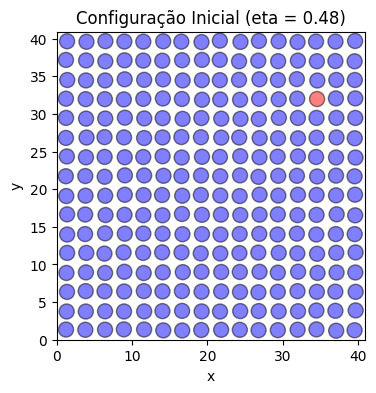

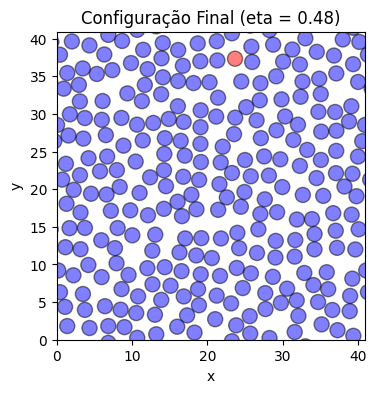

In [8]:
# Parâmetros da simulação (ajustáveis)
N = 256            # Número de partículas
r = 1.0            # Raio das partículas
delta = 0.1        # Deslocamento máximo em x e y

# Simulação para eta = 0.48
eta = 0.48
num_steps = int(1e5)
positions_initial_48, positions_48, L_48 = run_simulation(N, r, eta, num_steps, delta)

Tamanho da caixa: L = 33.422
Inicializando as posições das partículas...
Executando a simulação Monte Carlo...


100%|██████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39262.52it/s]


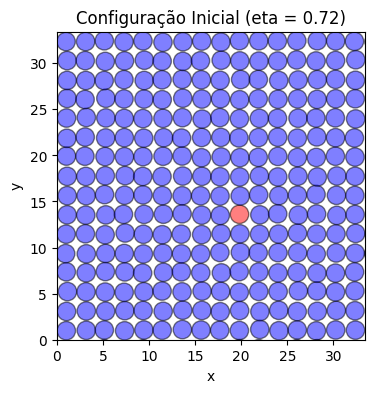

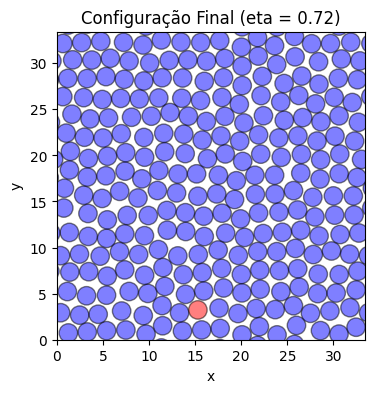

In [9]:
# Parâmetros da simulação (ajustáveis)
N = 256            # Número de partículas
r = 1.0            # Raio das partículas
delta = 0.1        # Deslocamento máximo em x e y

# Simulação para eta = 0.72
eta = 0.72
num_steps = int(1e5)
positions_initial_72, positions_72, L_72 = run_simulation(N, r, eta, num_steps, delta)

In [ ]:
# Simulação a longo prazo para eta = 0.72
eta = 0.72
num_steps = int(1e8)
delta_long = 0.05     # Ajuste de delta para melhor taxa de aceitação
positions_initial_long_72, positions_long_72, L_long_72 = run_simulation(N, r, eta, num_steps, delta_long, plot=False)

Tamanho da caixa: L = 33.422
Inicializando as posições das partículas...
Executando a simulação Monte Carlo...


 82%|█████████████████████████████████████████████████████            | 81615744/100000000 [39:12<09:05, 33724.84it/s]

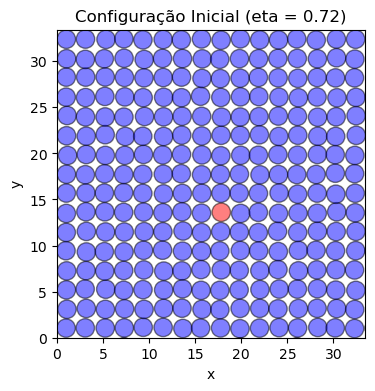

In [30]:
# Plotar as configurações inicial e final para a simulação longa
plot_particles(positions_initial_long_72, L_long_72, r, f"Configuração Inicial (eta = {eta})")

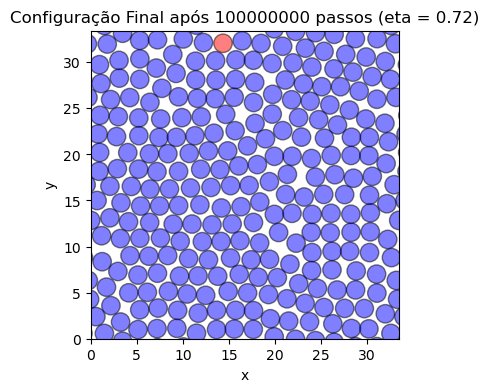

In [32]:
# Plotar as configurações inicial e final para a simulação longa
plot_particles(positions_long_72, L_long_72, r, f"Configuração Final após {num_steps} passos (eta = {eta})")